In [2]:
%matplotlib inline

from utils import load_new_data

import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
res_dir = './data'
data_dir = './new_data'

targets = os.listdir(data_dir)
splits = ['cv', 'bac']
split_ids = np.arange(5)

In [4]:
errors = []
uncs = []

for target, split, split_id in product(targets, splits, split_ids):

    train_dataset, test_dataset, sim, train_ids, test_ids, sim_ids = load_new_data(target, split, split_id)

    y_test = test_dataset.y.flatten()

    results_path = os.path.join(res_dir, target, split, f"large_result_{split_id}.npz")
    results = np.load(results_path)

    y_pred = results['y_pred'] 
    unc = results['unc']
    
    mse = (y_test - y_pred)**2
    
    errors.append(mse)
    uncs.append(unc)

uncs = np.concatenate(uncs)
errors = np.concatenate(errors)   

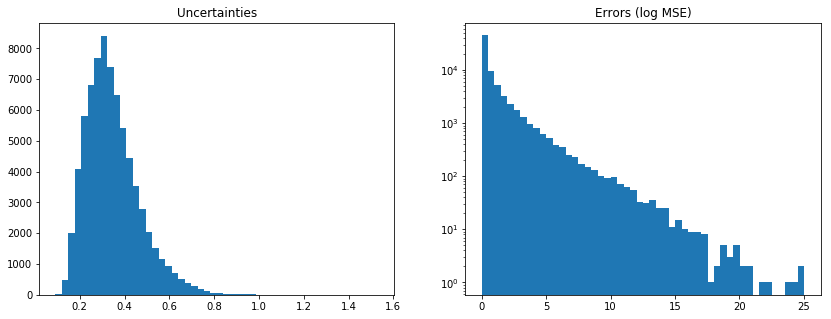

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14, 5))
axes[0].hist(uncs, bins=50)
axes[0].set_title("Uncertainties")
axes[1].hist(errors, bins=50, log=True)
_ = axes[1].set_title("Errors (log MSE)")

In [6]:
unc_thold = np.percentile(uncs, 5)
error_thold = np.percentile(errors, 95)

In [7]:
found = []

for target, split, split_id in product(targets, splits, split_ids):

    train_dataset, test_dataset, sim, train_chids, test_chids, sim_ids = load_new_data(target, split, split_id)
    
    y_train = train_dataset.y.flatten()
    y_test = test_dataset.y.flatten()

    results_path = os.path.join(res_dir, target, split, f"large_result_{split_id}.npz")
    results = np.load(results_path)

    y_pred = results['y_pred'] 
    unc = results['unc']
    
    mse = (y_test - y_pred)**2
    
    wrong_preds = set(np.where(mse >= error_thold)[0])
    certain_preds = set(np.where(unc <= unc_thold)[0])
    
    suspects = wrong_preds.intersection(certain_preds)
    
    if len(suspects) > 0:
        
        for suspect_id in suspects:
            
            chembl_id = test_chids[suspect_id]
            sims = []
            
            for chid in sim_ids[suspect_id]:
                idx = np.where(train_chids == chid)[0]
                assert len(idx) == 1
                sims.append((chid, y_train[idx][0]))
            
            found.append({'chembl_id': chembl_id,
                          'y_pred': y_pred[suspect_id],
                          'y_true': y_test[suspect_id],
                          'unc': unc[suspect_id],
                          'sims': sims,
                          'target': target,
                          'split': split,
                          'split_id': split_id})

In [8]:
from pprint import pprint

pprint(found)

[{'chembl_id': 'CHEMBL360055',
  'sims': [('CHEMBL1182634', 1.6434526),
           ('CHEMBL3041159', 1.2879546),
           ('CHEMBL332320', 1.7246854),
           ('CHEMBL121059', 0.7596679),
           ('CHEMBL1180282', 1.0413927),
           ('CHEMBL1184139', 1.5910646),
           ('CHEMBL72506', 2.9590414),
           ('CHEMBL74736', 2.1303337),
           ('CHEMBL2111176', 0.61109805),
           ('CHEMBL1180331', 1.243038)],
  'split': 'cv',
  'split_id': 3,
  'target': 'CHEMBL216',
  'unc': 0.18643531,
  'y_pred': 1.3826572,
  'y_true': 3.93},
 {'chembl_id': 'CHEMBL1851893',
  'sims': [('CHEMBL2413153', 1.5693738),
           ('CHEMBL2299002', 0.113943346),
           ('CHEMBL2298824', 1.1003705),
           ('CHEMBL1684128', 1.9444827),
           ('CHEMBL1684134', 2.2405493),
           ('CHEMBL1684135', 2.149219),
           ('CHEMBL2298829', -0.7212464),
           ('CHEMBL2298800', 3.0),
           ('CHEMBL2443005', 2.6237411),
           ('CHEMBL2443007', 2.7649717)],
  '